<h2>Variational Quantum Algorithm for solving Poisson equation</h2>

The accompanying python script 'vqa_poisson.py' contains the implemented algorithm <br>
(see H. Liu et.al., Phys.Rev.A 104, 022418 (2021); improved: Y. Sato et.al., arXiv:2106.09333v2 (2022)) 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, Aer
from qiskit.utils import QuantumInstance

#note: vqa_poisson.py must be in the same directory as this notebook (or adjust sys.path)
from vqa_poisson import VQApoisson

In [2]:
def experiment(bc, num_trials, num_qubits_list, num_layers, qins):
    
    print('-----------'+bc+' boundary condition --------------')
    
    data = {'num_qubits':[], 'obj_count':[], 'circ_count':[], 'iter_count':[], 'err':[], 'params':[], 'q_sol':[], 'cl_sol':[]}
    
    for num_qubits in num_qubits_list:
        print('-------------------------')
        print('num_qubits:', num_qubits)
        
        # set oracle for f vector
        oracle_f = QuantumCircuit(num_qubits)
        oracle_f.x(num_qubits-1)
        oracle_f.h(oracle_f.qubits)
    
        # set vqa instance
        # reduce tolerance? (default: c=1e-3)
        # reduction to c=0.01 is ok for periodic boundary condition but not Neumann (see plots)
        vqa = VQApoisson(num_qubits, num_layers, bc, oracle_f=oracle_f, qinstance=qins,c=0.01)

        obj_counts = []
        circ_counts = []
        iter_counts = []
        err = []
        params = []
        q_sol = []
    
        for seed in range(num_trials):
        
            np.random.seed(seed)
        
            x0 = list(4*np.pi*np.random.rand(vqa.num_params))
            res = vqa.minimize(x0, method='bfgs', save_logs=True)
    
            obj_counts.append(vqa.objective_counts)
            circ_counts.append(vqa.circuit_counts)
            iter_counts.append(len(vqa.objective_count_logs))
            err.append(vqa.get_errors(res['x'])['trace'])
            params.append(res['x'])
            q_sol.append(vqa.get_sol(res['x']).real)
            
            print('trial:', seed, 'Err.:', err[-1])
        
        data['num_qubits'].append(num_qubits)
        data['obj_count'].append(obj_counts)
        data['circ_count'].append(circ_counts)
        data['iter_count'].append(iter_counts)
        data['err'].append(err)
        data['params'].append(params)
        data['q_sol'].append(q_sol)
        data['cl_sol'].append(vqa.get_cl_sol().real)
        
    return data

In [3]:
def plot_solution_vectors(q_sol, cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(q_sol, label='quantum', color='black')
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(q_sol)
    qnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.65, 'Norm (quantum) = %.1f'%(qnorm), transform=ax.transAxes)
    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)
    
    return fig, ax

<h3>Example 1: periodic boundary condition</h3>

In [6]:
t0 = time.time()
optimizer = 'bfgs'
num_layers = 5
num_trials = 1
num_qubits_list = [4]  #list(range(3,10))
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)

# bc: Periodic
data_p = experiment('Periodic', num_trials, num_qubits_list, num_layers, qins)
time_p = time.time()-t0
print('elapsed time (sec): %.2e'%time_p)

-----------Periodic boundary condition --------------
-------------------------
num_qubits: 4
It.: 00001, Obj.: -5.277682e-01
It.: 00002, Obj.: -5.290735e-01
It.: 00003, Obj.: -9.711526e-01
It.: 00004, Obj.: -1.099600e+00
It.: 00005, Obj.: -1.277585e+00
It.: 00006, Obj.: -1.594868e+00
It.: 00007, Obj.: -1.925347e+00
It.: 00008, Obj.: -2.022160e+00
It.: 00009, Obj.: -2.171189e+00
It.: 00010, Obj.: -2.361722e+00
It.: 00011, Obj.: -2.425088e+00
It.: 00012, Obj.: -2.478338e+00
It.: 00013, Obj.: -2.505395e+00
It.: 00014, Obj.: -2.544565e+00
It.: 00015, Obj.: -2.559768e+00
It.: 00016, Obj.: -2.565377e+00
It.: 00017, Obj.: -2.572591e+00
It.: 00018, Obj.: -2.574431e+00
It.: 00019, Obj.: -2.577212e+00
It.: 00020, Obj.: -2.578715e+00
It.: 00021, Obj.: -2.580560e+00
It.: 00022, Obj.: -2.580946e+00
It.: 00023, Obj.: -2.581425e+00
It.: 00024, Obj.: -2.581855e+00
It.: 00025, Obj.: -2.582217e+00
It.: 00026, Obj.: -2.582459e+00
It.: 00027, Obj.: -2.582685e+00
It.: 00028, Obj.: -2.582947e+00
It.: 00029

<h3>Example 2: Dirichlet boundary condition<h3>

In [7]:
t0 = time.time()
optimizer = 'bfgs'
num_layers = 5
num_trials = 1
num_qubits_list = [4]
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)

#bc: Dirichlet
data_d = experiment('Dirichlet', num_trials, num_qubits_list, num_layers, qins) 
time_d = time.time()-t0
print('elapsed time (sec): %.2e'%time_d)

-----------Dirichlet boundary condition --------------
-------------------------
num_qubits: 4
It.: 00001, Obj.: -4.941822e-01
It.: 00002, Obj.: -4.950259e-01
It.: 00003, Obj.: -7.592141e-01
It.: 00004, Obj.: -9.585573e-01
It.: 00005, Obj.: -1.288231e+00
It.: 00006, Obj.: -1.493596e+00
It.: 00007, Obj.: -1.714955e+00
It.: 00008, Obj.: -2.008630e+00
It.: 00009, Obj.: -2.178642e+00
It.: 00010, Obj.: -2.301113e+00
It.: 00011, Obj.: -2.477870e+00
It.: 00012, Obj.: -2.703041e+00
It.: 00013, Obj.: -2.808632e+00
It.: 00014, Obj.: -2.856640e+00
It.: 00015, Obj.: -2.900865e+00
It.: 00016, Obj.: -2.923643e+00
It.: 00017, Obj.: -2.936564e+00
It.: 00018, Obj.: -2.949992e+00
It.: 00019, Obj.: -2.958485e+00
It.: 00020, Obj.: -2.970510e+00
It.: 00021, Obj.: -2.981596e+00
It.: 00022, Obj.: -2.986910e+00
It.: 00023, Obj.: -2.987759e+00
It.: 00024, Obj.: -2.989345e+00
It.: 00025, Obj.: -2.992146e+00
It.: 00026, Obj.: -2.996467e+00
It.: 00027, Obj.: -2.999989e+00
It.: 00028, Obj.: -3.000948e+00
It.: 0002

<h3>Example 3: v.Neumann boundary condition<h3>

In [8]:
t0 = time.time()
optimizer = 'bfgs'
num_layers = 5
num_trials = 1
num_qubits_list = [5]
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)

# bc: Neumann
data_n = experiment('Neumann', num_trials, num_qubits_list, num_layers, qins)
time_n = time.time()-t0
print('elapsed time (sec): %.2e'%time_n)

-----------Neumann boundary condition --------------
-------------------------
num_qubits: 5
It.: 00001, Obj.: -3.859908e-01
It.: 00002, Obj.: -3.860960e-01
It.: 00003, Obj.: -1.520444e+00
It.: 00004, Obj.: -1.569940e+00
It.: 00005, Obj.: -1.653309e+00
It.: 00006, Obj.: -2.055951e+00
It.: 00007, Obj.: -2.222098e+00
It.: 00008, Obj.: -2.307809e+00
It.: 00009, Obj.: -2.446391e+00
It.: 00010, Obj.: -2.912342e+00
It.: 00011, Obj.: -3.168083e+00
It.: 00012, Obj.: -3.325706e+00
It.: 00013, Obj.: -3.593386e+00
It.: 00014, Obj.: -4.085266e+00
It.: 00015, Obj.: -4.672398e+00
It.: 00016, Obj.: -5.011576e+00
It.: 00017, Obj.: -5.583803e+00
It.: 00018, Obj.: -6.410817e+00
It.: 00019, Obj.: -7.202702e+00
It.: 00020, Obj.: -7.410568e+00
It.: 00021, Obj.: -7.804991e+00
It.: 00022, Obj.: -8.537787e+00
It.: 00023, Obj.: -9.011130e+00
It.: 00024, Obj.: -9.266882e+00
It.: 00025, Obj.: -9.588767e+00
It.: 00026, Obj.: -1.008496e+01
It.: 00027, Obj.: -1.035705e+01
It.: 00028, Obj.: -1.047846e+01
It.: 00029,

It.: 00255, Obj.: -2.123675e+01
It.: 00256, Obj.: -2.123676e+01
It.: 00257, Obj.: -2.123678e+01
It.: 00258, Obj.: -2.123679e+01
It.: 00259, Obj.: -2.123679e+01
It.: 00260, Obj.: -2.123680e+01
It.: 00261, Obj.: -2.123680e+01
It.: 00262, Obj.: -2.123681e+01
It.: 00263, Obj.: -2.123681e+01
It.: 00264, Obj.: -2.123681e+01
It.: 00265, Obj.: -2.123681e+01
It.: 00266, Obj.: -2.123682e+01
It.: 00267, Obj.: -2.123682e+01
It.: 00268, Obj.: -2.123682e+01
It.: 00269, Obj.: -2.123683e+01
It.: 00270, Obj.: -2.123683e+01
It.: 00271, Obj.: -2.123683e+01
It.: 00272, Obj.: -2.123683e+01
It.: 00273, Obj.: -2.123683e+01
It.: 00274, Obj.: -2.123684e+01
It.: 00275, Obj.: -2.123684e+01
It.: 00276, Obj.: -2.123684e+01
It.: 00277, Obj.: -2.123684e+01
It.: 00278, Obj.: -2.123684e+01
It.: 00279, Obj.: -2.123685e+01
It.: 00280, Obj.: -2.123685e+01
It.: 00281, Obj.: -2.123685e+01
It.: 00282, Obj.: -2.123685e+01
It.: 00283, Obj.: -2.123685e+01
It.: 00284, Obj.: -2.123685e+01
It.: 00285, Obj.: -2.123686e+01
It.: 002

### Plots

Periodic boundary condition, num_qubits: 4


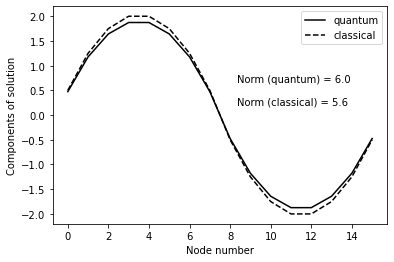

In [9]:
idx1, idx2 = 0, 0  #here: only one qubit setting
print('Periodic boundary condition, num_qubits:', data_p['num_qubits'][idx1])
q_sol = data_p['q_sol'][idx1][idx2]
cl_sol = data_p['cl_sol'][idx1]
pl=plot_solution_vectors(q_sol, cl_sol)

Dirichlet boundary condition, num_qubits: 4


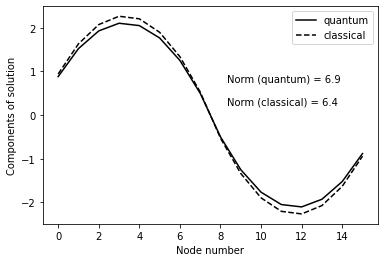

In [10]:
idx1, idx2 = 0, 0  #here: only one qubit setting
print('Dirichlet boundary condition, num_qubits:', data_d['num_qubits'][idx1])
q_sol = data_d['q_sol'][idx1][idx2]
cl_sol = data_d['cl_sol'][idx1]
pl=plot_solution_vectors(q_sol, cl_sol)

Neumann boundary condition, num_qubits: 5


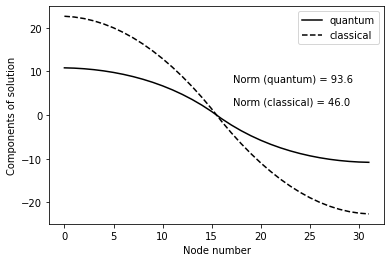

In [11]:
idx1, idx2 = 0, 0  #here: only one qubit setting
print('Neumann boundary condition, num_qubits:', data_n['num_qubits'][idx1])
q_sol = data_n['q_sol'][idx1][idx2]
cl_sol = data_n['cl_sol'][idx1]
pl=plot_solution_vectors(q_sol, cl_sol)

NOTE: Result for v.Neumann boundary condition is very bad if tolerance (parameter 'c' in VQApoisson) is much larger than 10<sup>-3</sup>! <br>

<h3>Display circuit for state preparation and shifting</h3>

[[ 2.001e+00 -9.990e-01  1.000e-03 ...  1.000e-03  1.000e-03 -9.990e-01]
 [-9.990e-01  2.001e+00 -9.990e-01 ...  1.000e-03  1.000e-03  1.000e-03]
 [ 1.000e-03 -9.990e-01  2.001e+00 ...  1.000e-03  1.000e-03  1.000e-03]
 ...
 [ 1.000e-03  1.000e-03  1.000e-03 ...  2.001e+00 -9.990e-01  1.000e-03]
 [ 1.000e-03  1.000e-03  1.000e-03 ... -9.990e-01  2.001e+00 -9.990e-01]
 [-9.990e-01  1.000e-03  1.000e-03 ...  1.000e-03 -9.990e-01  2.001e+00]]


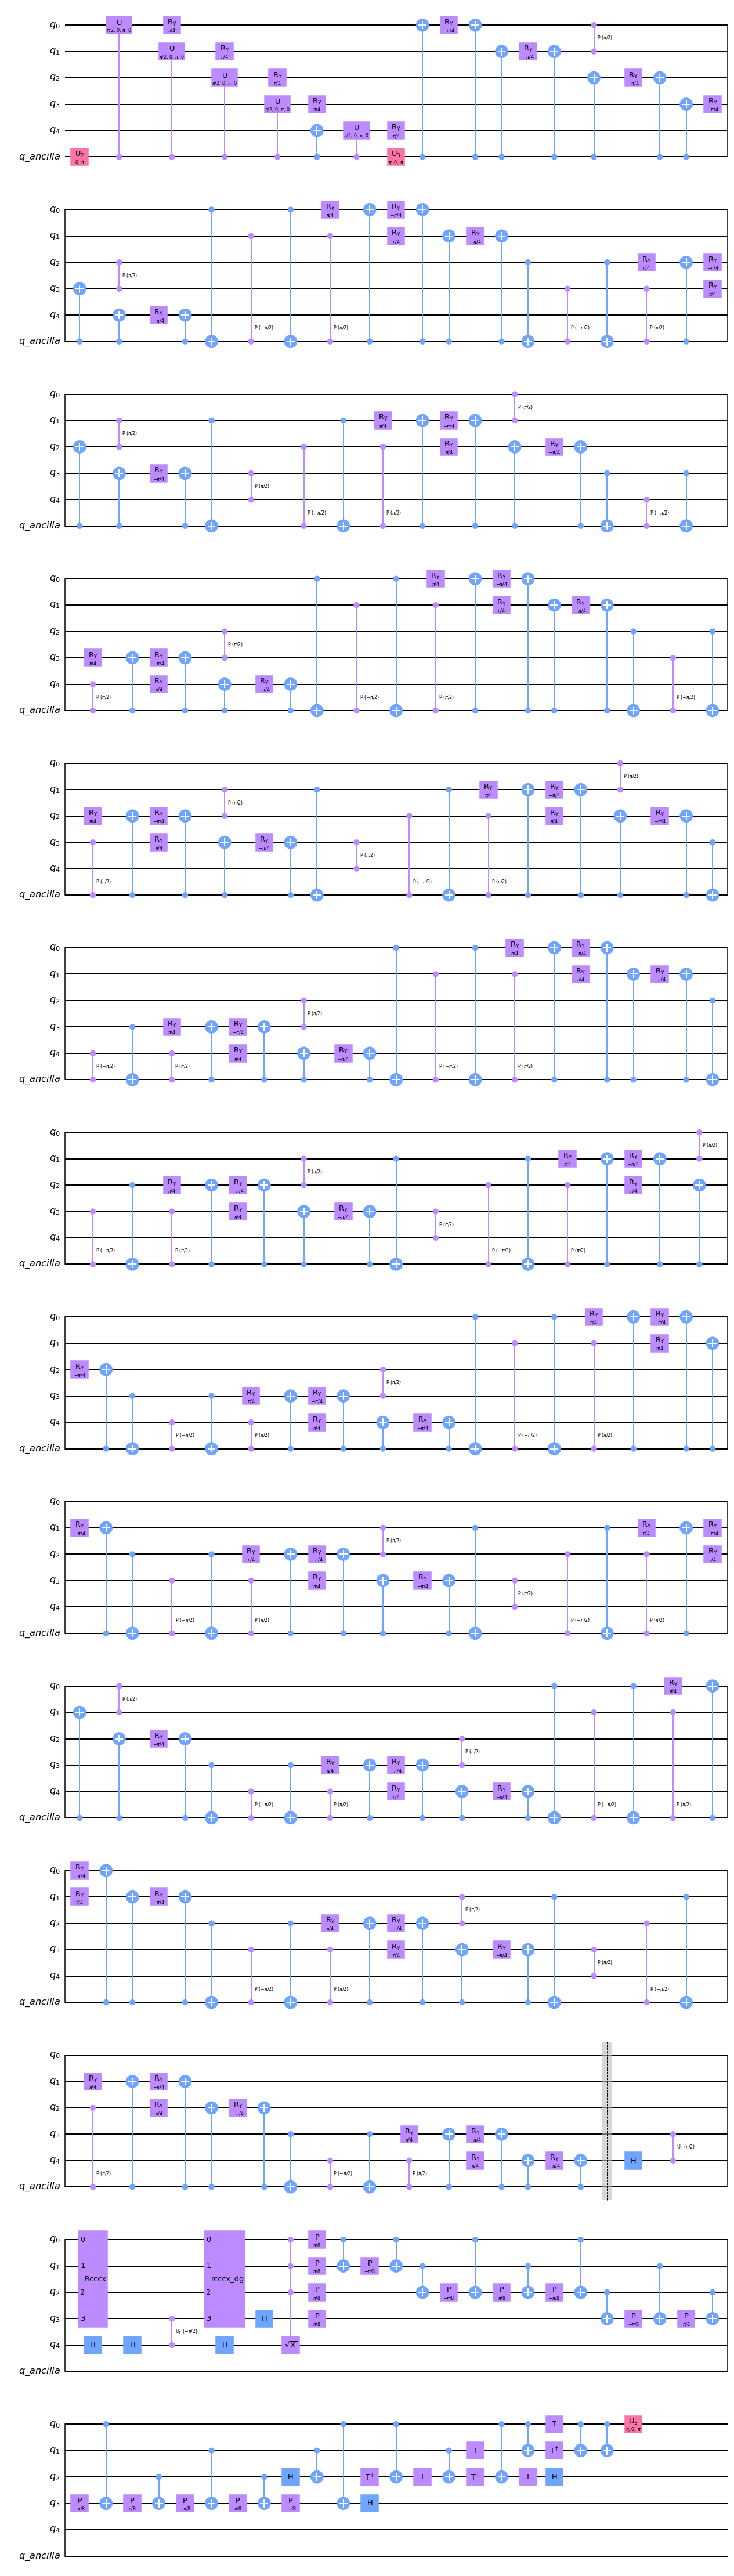

In [12]:
num_qubits=5
num_layers=5
bc='Periodic'

# set oracle for f vector
oracle_f = QuantumCircuit(num_qubits)
oracle_f.x(num_qubits-1)
oracle_f.h(oracle_f.qubits)

qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)
vqa = VQApoisson(num_qubits, num_layers, bc, oracle_f=oracle_f, qinstance=qins)

#x0 = list(4*np.pi*np.random.rand(vqa.num_params))
x0 = list([np.pi/2.]*vqa.num_params)

qc0=QuantumCircuit(QuantumRegister(num_qubits, 'q'),QuantumRegister(1, 'q_ancilla'))

qc=vqa.state_preparation(qc0,params=x0)
qc.barrier()
qc = vqa.shift_add(qc)
print(vqa.get_A_matrix())
qc.decompose().draw('mpl')